In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import PIL
import PIL.Image

import tensorflow as tf

from tensorflow.keras import layers

import pathlib
import os
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv("train.csv", index_col=0)
print(df.shape)
df.head()

(1821, 4)


,healthy,multiple_diseases,rust,scab
image_id,,,,
Train_0,0,0,0,1
Train_1,0,1,0,0
Train_2,1,0,0,0
Train_3,0,0,1,0
Train_4,1,0,0,0


In [5]:
import shutil
from shutil import copyfile

if os.path.exists('temp'):
    shutil.rmtree('temp')

os.mkdir('temp')
os.mkdir('temp/images')
os.mkdir('temp/images/healthy')
os.mkdir('temp/images/multiple_diseases')
os.mkdir('temp/images/rust')
os.mkdir('temp/images/scab')

In [7]:
SOURCE = 'images'

SPLIT_DIR = 'temp/images/'

# copy images to train directory
for index, data in df.iterrows():
    label = df.columns[np.argmax(data)]
    filepath = os.path.join(SOURCE, index + ".jpg")
    destination = os.path.join(SPLIT_DIR, label, index + ".jpg")
    copyfile(filepath, destination)

In [8]:
for subdir in os.listdir(SPLIT_DIR):
    print(subdir, len(os.listdir(os.path.join(SPLIT_DIR, subdir))))

healthy 516
multiple_diseases 91
rust 622
scab 592


In [9]:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    'temp/images',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

Found 1821 files belonging to 4 classes.
Using 1457 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    'temp/images',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

Found 1821 files belonging to 4 classes.
Using 364 files for validation.


In [12]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(num_classes, class_names)

4 ['healthy', 'multiple_diseases', 'rust', 'scab']


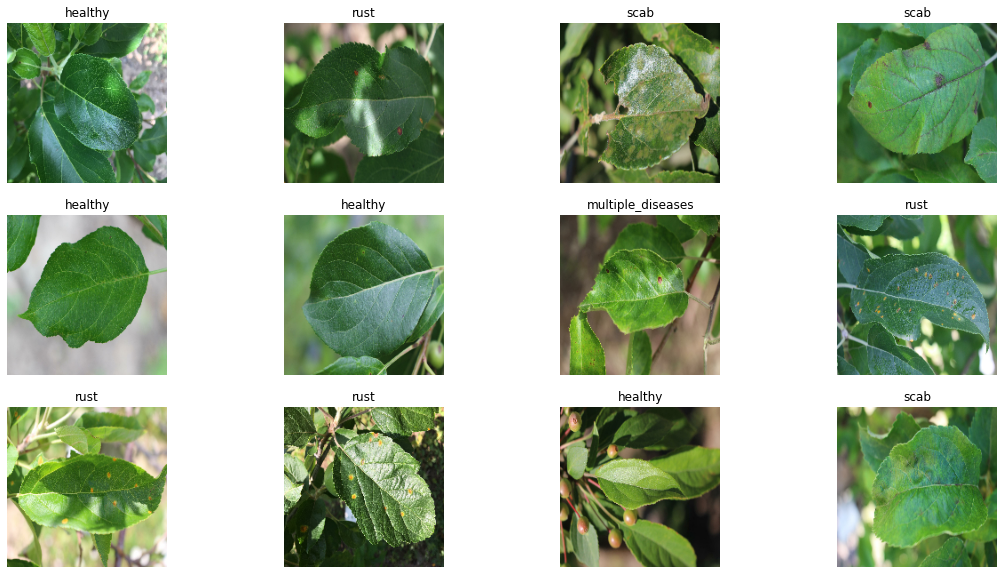

In [28]:
plt.figure(figsize=(19, 10))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[list(labels[i]).index(1)])
        plt.axis("off")

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

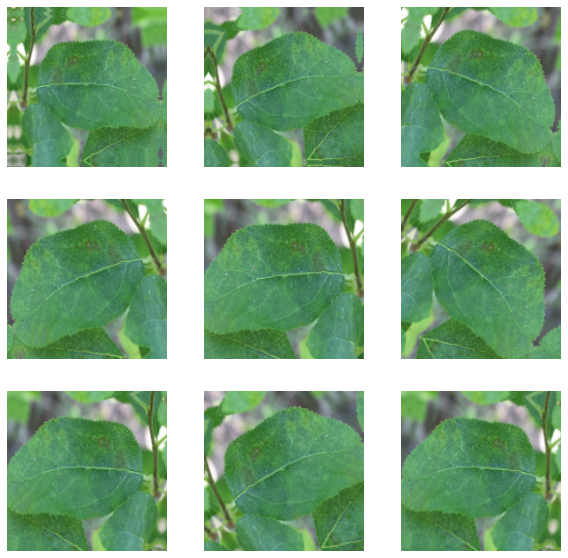

In [16]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [17]:
model = tf.keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [18]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  monitor="val_loss",
                                                  verbose=2,
                                                  mode="auto")
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", 
                                                monitor="val_loss",
                                                mode="auto",
                                                verbose=2,
                                                save_best_only=True)
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [21]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping,checkpoint]
)

Epoch 1/10
46/46 [==============================] - ETA: 0s - loss: 1.2466 - accuracy: 0.3191
Epoch 1: val_loss improved from inf to 1.28006, saving model to best.h5
46/46 [==============================] - 41s 895ms/step - loss: 1.2466 - accuracy: 0.3191 - val_loss: 1.2801 - val_accuracy: 0.3269
Epoch 2/10
46/46 [==============================] - ETA: 0s - loss: 1.2321 - accuracy: 0.3617
Epoch 2: val_loss improved from 1.28006 to 1.25049, saving model to best.h5
46/46 [==============================] - 34s 740ms/step - loss: 1.2321 - accuracy: 0.3617 - val_loss: 1.2505 - val_accuracy: 0.3571
Epoch 3/10
46/46 [==============================] - ETA: 0s - loss: 1.2005 - accuracy: 0.4214
Epoch 3: val_loss did not improve from 1.25049
46/46 [==============================] - 36s 772ms/step - loss: 1.2005 - accuracy: 0.4214 - val_loss: 1.2895 - val_accuracy: 0.3929
Epoch 4/10
46/46 [==============================] - ETA: 0s - loss: 1.0770 - accuracy: 0.5189
Epoch 4: val_loss improved from 1

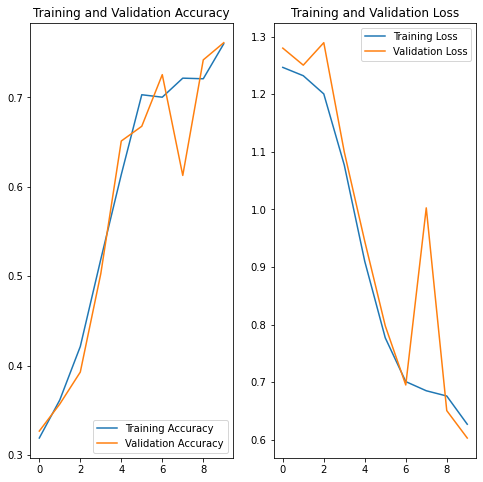

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = len(acc)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
from keras_preprocessing import image

test_set = pd.read_csv("test.csv", index_col=0)

X_test = []
for index, data in test_set.iterrows():
    filepath = os.path.join(SOURCE, index + ".jpg")
    img = image.load_img(filepath, target_size=(img_height, img_width))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    X_test.append(x)
    
X_test = np.vstack(X_test)

In [26]:
predictions = model.predict(X_test, batch_size= 10)
score = tf.nn.softmax(predictions)
score = np.array(score)
df_out = pd.concat([test_set.reset_index(), pd.DataFrame(score, columns = class_names)], axis=1).set_index("image_id")
df_out.to_csv('submission.csv')
df_out.head()

,healthy,multiple_diseases,rust,scab
image_id,,,,
Test_0,0.177203,0.185509,0.460086,0.177203
Test_1,0.182909,0.217792,0.416384,0.182915
Test_2,0.233755,0.190860,0.187510,0.387875
Test_3,0.333642,0.194318,0.192332,0.279708
Test_4,0.176695,0.183099,0.463510,0.176695
